In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xception-mini-check-data/y_train.npy
/kaggle/input/xception-mini-check-data/y_test.npy
/kaggle/input/xception-mini-check-data/y.npy
/kaggle/input/xception-mini-check-data/X_test.npy
/kaggle/input/xception-mini-check-data/X_train.npy
/kaggle/input/xception-mini-check-data/fer2013.csv
/kaggle/input/xception-mini-check-data/X.npy
/kaggle/input/fer2013balanced/y_val_balanced.npy
/kaggle/input/fer2013balanced/X_train_balanced.npy
/kaggle/input/fer2013balanced/y_train_balanced.npy
/kaggle/input/fer2013balanced/X_val_balanced.npy
/kaggle/input/fer2013balanced/X_temp_balanced.npy
/kaggle/input/fer2013balanced/y_test_balanced.npy
/kaggle/input/fer2013balanced/y_temp_balanced.npy
/kaggle/input/fer2013balanced/X_test_balanced.npy


In [52]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

In [53]:
facialexpression_df = pd.read_csv('../FERData/CSV/fer2013.csv')
facialexpression_df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [54]:
# function to convert pixel values in string format to array format
facialexpression_df['pixels'][0] # String format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [55]:
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: string2array(x))


In [56]:
facialexpression_df.head()

emotion                                             pixels     Usage
0        0  [[[70.0], [80.0], [82.0], [72.0], [58.0], [58....  Training
1        0  [[[151.0], [150.0], [147.0], [155.0], [148.0],...  Training
2        2  [[[231.0], [212.0], [156.0], [164.0], [174.0],...  Training
3        4  [[[24.0], [32.0], [36.0], [30.0], [32.0], [23....  Training
4        6  [[[4.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...  Training

In [57]:
facialexpression_df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [58]:
label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

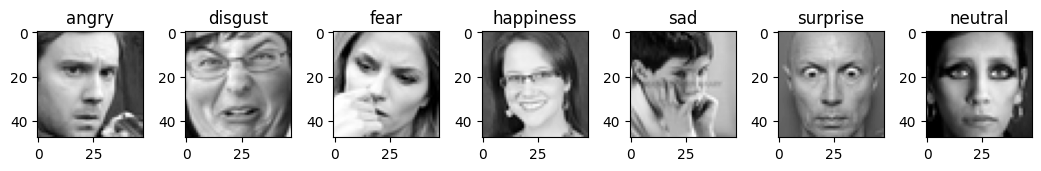

In [59]:
num_rows = 2
num_cols = 8

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
axes = axes.flatten()

emotions = [0, 1, 2, 3, 4, 5, 6]

for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
    img = data['pixels'].item()
    img = img.reshape(48, 48) 
    ax = axes[i]
    ax.set_title(label_to_text[i])
    ax.imshow(img, cmap='gray')

for i in range(len(emotions), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()

plt.show()

In [60]:
facialexpression_df.emotion.value_counts().index
facialexpression_df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

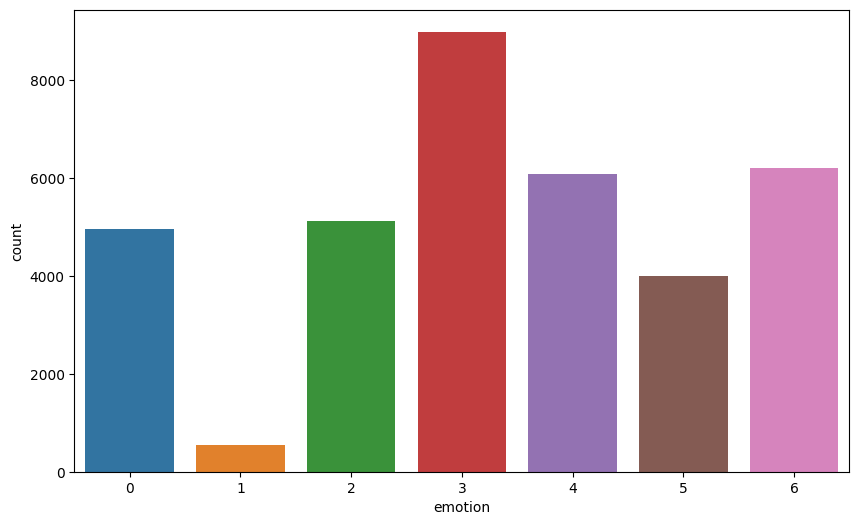

In [61]:
plt.figure(figsize = (10,6))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

# DATA PREPARATION AND IMAGE AUGMENTATION

In [62]:
# Separate data based on 'Usage' column
train_data = facialexpression_df[facialexpression_df['Usage'] == 'Training']
test_data = facialexpression_df[facialexpression_df['Usage'] == 'PublicTest']
val_data = facialexpression_df[facialexpression_df['Usage'] == 'PrivateTest']

#Training Data
X_train = train_data['pixels']
y_train = train_data['emotion']

#Testing Data
X_test = test_data['pixels']
y_test = test_data['emotion']

#Validation Data
X_val = val_data['pixels']
y_val = val_data['emotion'] 

In [63]:
X_train = train_data['pixels']
y_train = to_categorical(train_data['emotion'])

X_test = test_data['pixels']
y_test = to_categorical(test_data['emotion'])

X_val = val_data['pixels']
y_val = to_categorical(val_data['emotion'])

In [64]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(28709 , 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(3589 , 48, 48, 1)

X_val = np.stack(X_val, axis = 0)
X_val = X_val.reshape(3589 , 48, 48, 1)

In [65]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)
(3589, 48, 48, 1) (3589, 7)


In [66]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_test/255

In [67]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

# Developing and Training a Deep Learning Model for Emotion Expression Classification

In [68]:
# BUILD CUSTOM DEEP RESIDUAL NEURAL NETWORK FOR FACIAL POINTS DETECTION MODEL
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)
  # stride equal to 1 , that means they're going to be shifting and scanning only by one pixel
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(7, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

Resnet18Emo = Model( inputs= X_input, outputs = X, name = 'Resnet18')

Resnet18Emo.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 54, 54, 1)            0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 24, 24, 64)           3200      ['zero_padding2d_2[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1[0][0]']        

In [69]:
# Xception Model
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [256,512, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

shape_x = 48
shape_y = 48
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [70]:
xception = Model(inputs, outputs,name = 'Xception')

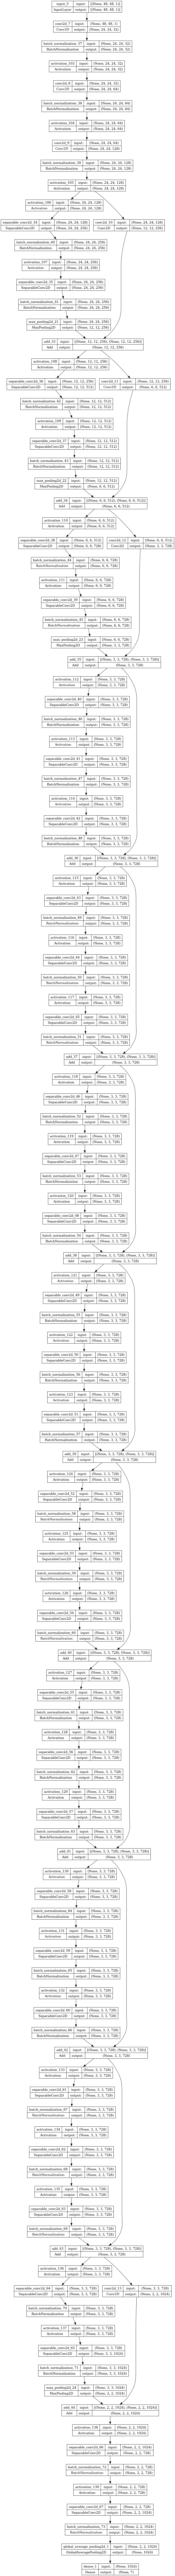

In [71]:
plot_model(xception, to_file='Xception.png', show_shapes=True, show_layer_names=True)

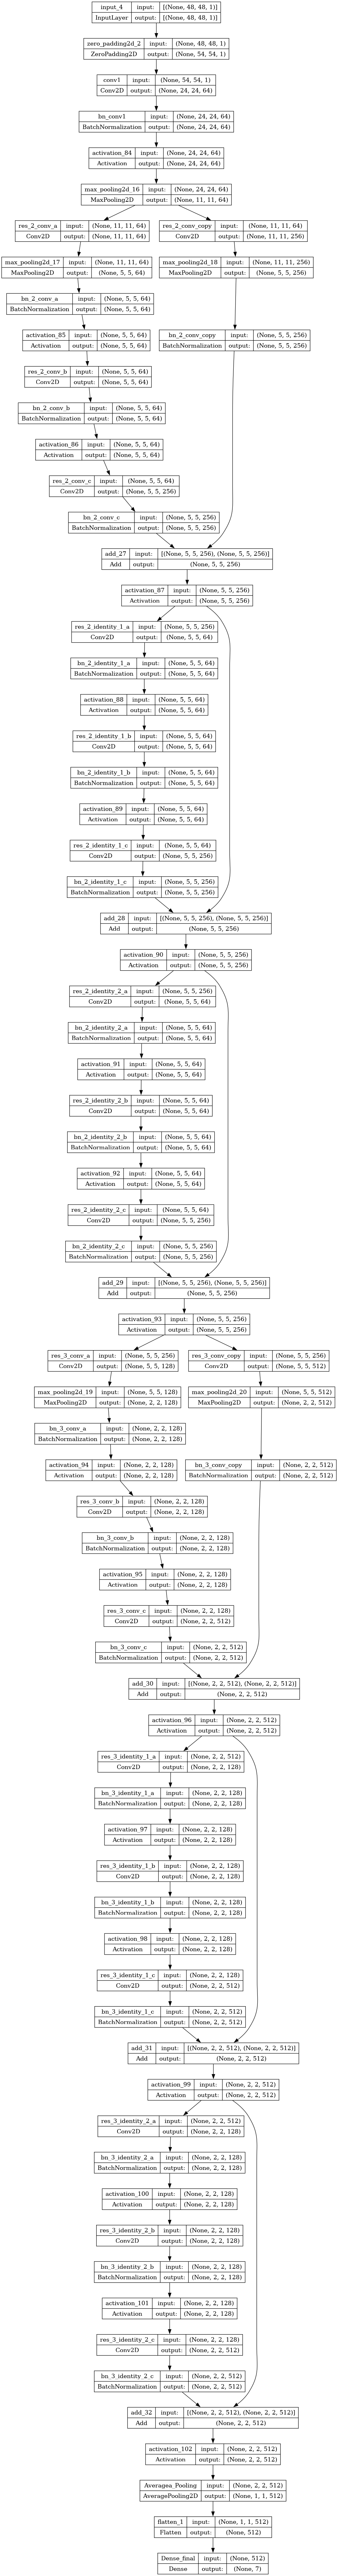

In [110]:
plot_model(Resnet18Emo, to_file='Resnet18Emo.png', show_shapes=True, show_layer_names=True)

In [72]:
xception.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "Emotion_weights_Xception_Std.hdf5", verbose = 1, save_best_only=True)

In [73]:
history_xception_std = xception.fit(train_datagen.flow(X_train, y_train, batch_size=64),validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 1.6026 - accuracy: 0.3666
Epoch 1: val_loss improved from inf to 2.03378, saving model to Emotion_weights_Xception_Std.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 95s 142ms/step - loss: 1.6026 - accuracy: 0.3666 - val_loss: 2.0338 - val_accuracy: 0.1663
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.4748
Epoch 2: val_loss did not improve from 2.03378
448/448 [==============================] - 60s 133ms/step - loss: 1.3670 - accuracy: 0.4748 - val_loss: 4.0640 - val_accuracy: 0.2391
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.2666 - accuracy: 0.5193
Epoch 3: val_loss did not improve from 2.03378
448/448 [==============================] - 60s 134ms/step - loss: 1.2666 - accuracy: 0.5193 - val_loss: 2.5697 - val_accuracy: 0.3862
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.2034 - accuracy: 0.5479
Epoch 4: val_loss improved from 2.03378 to 1.56531, saving model to Emotion_weights_Xception_Std.hdf5
448/448 [==============================] - 61s 136ms/step - loss: 1.2034 - accuracy: 0.5479 - val_loss: 1.5653 

In [74]:
# saving the model architecture to json file

model_json = xception.to_json()
with open("FacialExpression-model-Xception-std.json","w") as json_file:
  json_file.write(model_json)

In [75]:
score = xception.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 2s 15ms/step - loss: 1.2919 - accuracy: 0.6322
Test Accuracy: 0.6322095394134521


In [76]:
predicted_classes = np.argmax(xception.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

113/113 [==============================] - 2s 13ms/step


<Axes: >

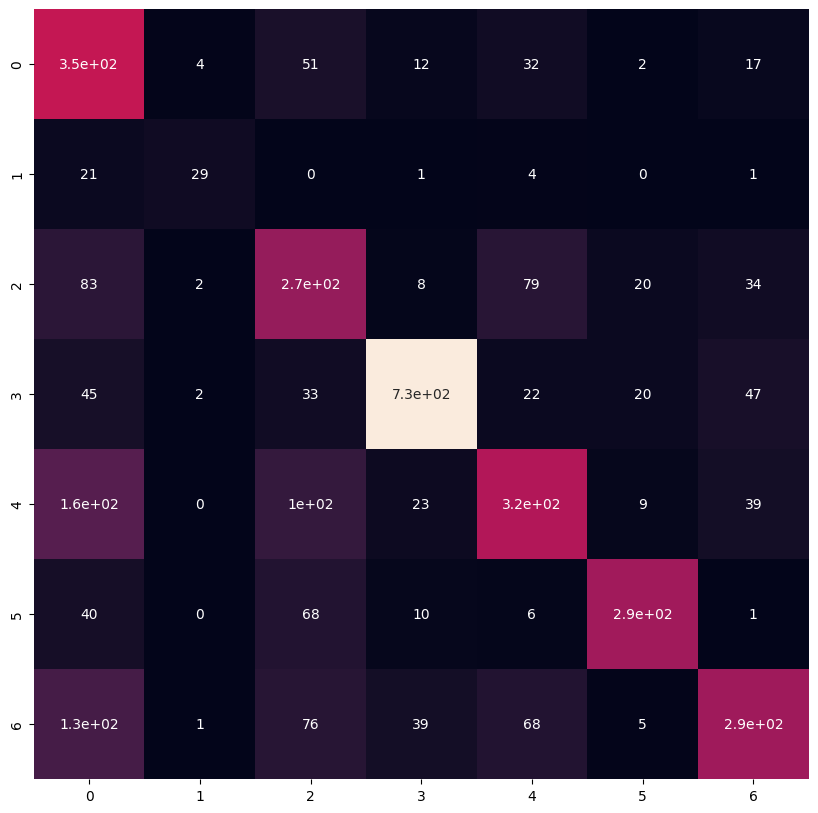

In [77]:
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [78]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.42      0.75      0.54       467
           1       0.76      0.52      0.62        56
           2       0.45      0.54      0.49       496
           3       0.89      0.81      0.85       895
           4       0.60      0.49      0.54       653
           5       0.84      0.70      0.76       415
           6       0.67      0.47      0.56       607

    accuracy                           0.63      3589
   macro avg       0.66      0.61      0.62      3589
weighted avg       0.67      0.63      0.64      3589



Text(0.5, 1.0, 'Accuracy Curves - Xception FER2013 Std')

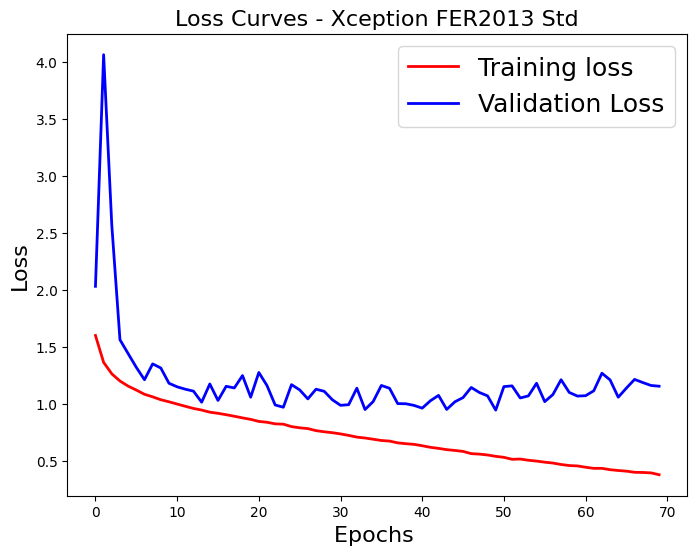

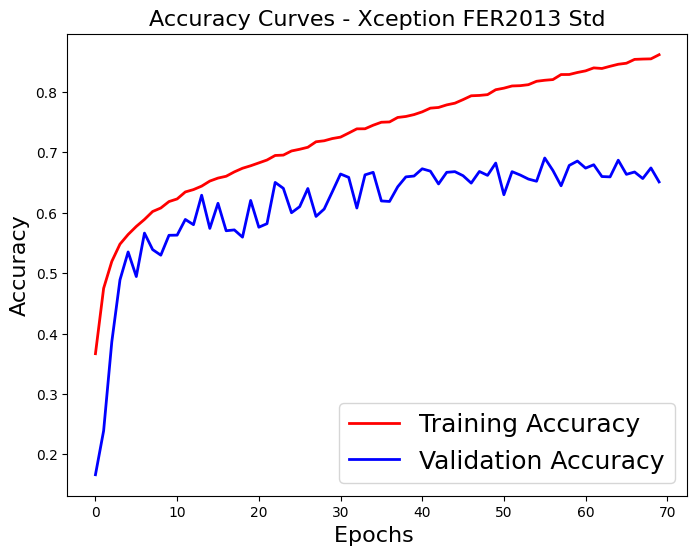

In [79]:
#Plotting accuracy and loss curves for Xception Model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_xception_std.history['loss'],'r',linewidth=2.0)
plt.plot(history_xception_std.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves - Xception FER2013 Std',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_xception_std.history['accuracy'],'r',linewidth=2.0)
plt.plot(history_xception_std.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves - Xception FER2013 Std',fontsize=16)

In [80]:
Resnet18Emo.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "Emotion_weights_Res2018_Std.hdf5", verbose = 1, save_best_only=True)

history_Resnet18Emo_std = Resnet18Emo.fit(train_datagen.flow(X_train, y_train, batch_size=64),validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,epochs= 100, callbacks=[checkpointer, earlystopping])



Epoch 1/100
447/448 [============================>.] - ETA: 0s - loss: 1.8311 - accuracy: 0.2945
Epoch 1: val_loss improved from inf to 1.90410, saving model to Emotion_weights_Res2018_Std.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 29s 35ms/step - loss: 1.8306 - accuracy: 0.2948 - val_loss: 1.9041 - val_accuracy: 0.1939
Epoch 2/100
447/448 [============================>.] - ETA: 0s - loss: 1.6239 - accuracy: 0.3807
Epoch 2: val_loss did not improve from 1.90410
448/448 [==============================] - 15s 32ms/step - loss: 1.6237 - accuracy: 0.3810 - val_loss: 2.0189 - val_accuracy: 0.2686
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.4922 - accuracy: 0.4331
Epoch 3: val_loss improved from 1.90410 to 1.67410, saving model to Emotion_weights_Res2018_Std.hdf5
448/448 [==============================] - 15s 33ms/step - loss: 1.4922 - accuracy: 0.4331 - val_loss: 1.6741 - val_accuracy: 0.3447
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.4279 - accuracy: 0.4633
Epoch 4: val_loss did not improve from 1.67410
448/448 [==============================] - 15s 32ms/step - loss: 1.4279 - accuracy: 0.4633 - val_loss: 1.9669 - val

113/113 [==============================] - 1s 4ms/step - loss: 1.3651 - accuracy: 0.5957
Test Accuracy: 0.5957090854644775
113/113 [==============================] - 1s 3ms/step


<Axes: >

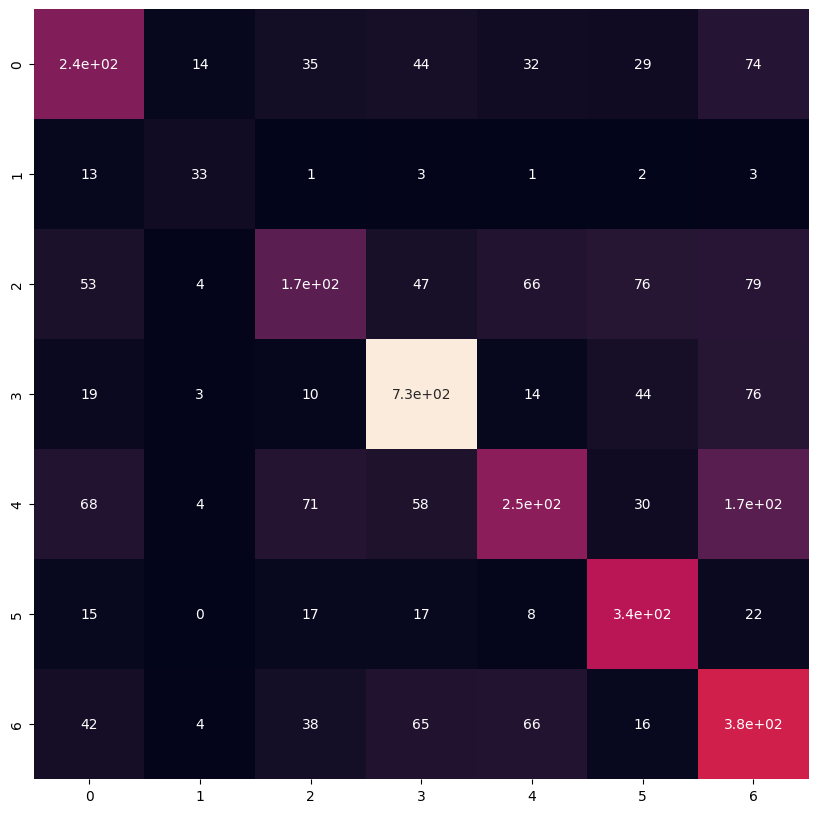

In [81]:
# saving the model architecture to json file

model_json = Resnet18Emo.to_json()
with open("FacialExpression-model-Res2018-std.json","w") as json_file:
  json_file.write(model_json)

score = Resnet18Emo.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

predicted_classes = np.argmax(Resnet18Emo.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

cm_Resnet18Emo_std = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm_Resnet18Emo_std, annot = True, cbar = False)


In [82]:

print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       467
           1       0.53      0.59      0.56        56
           2       0.50      0.34      0.41       496
           3       0.76      0.81      0.78       895
           4       0.58      0.39      0.46       653
           5       0.63      0.81      0.71       415
           6       0.47      0.62      0.54       607

    accuracy                           0.60      3589
   macro avg       0.57      0.58      0.57      3589
weighted avg       0.59      0.60      0.59      3589



Text(0.5, 1.0, 'Accuracy Curves - Res18Custom FER2013 Std')

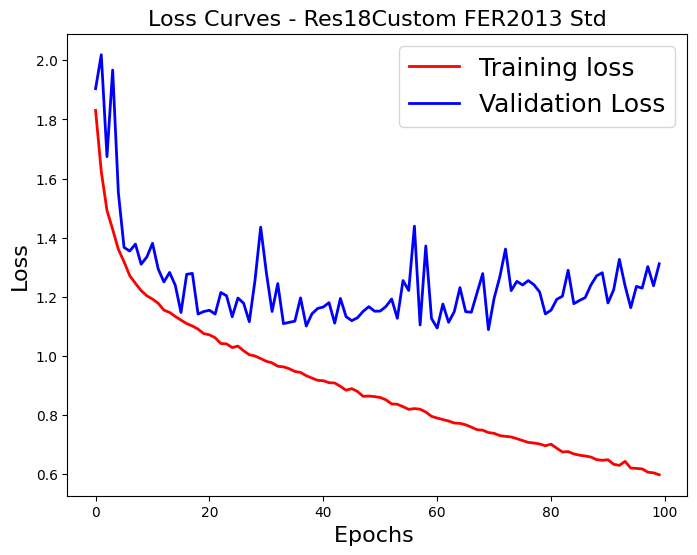

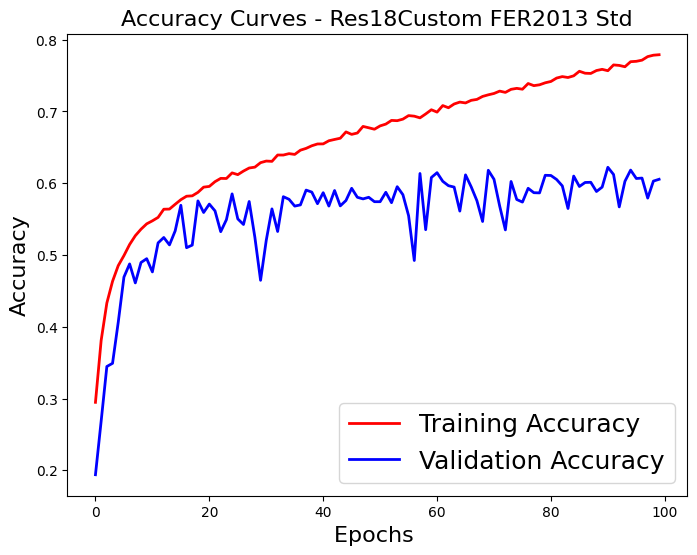

In [83]:
#Plotting accuracy and loss curves for Res18Custom Model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_Resnet18Emo_std.history['loss'],'r',linewidth=2.0)
plt.plot(history_Resnet18Emo_std.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves - Res18Custom FER2013 Std',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_Resnet18Emo_std.history['accuracy'],'r',linewidth=2.0)
plt.plot(history_Resnet18Emo_std.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves - Res18Custom FER2013 Std',fontsize=16)

# Establishing Equally Balanced Dataset Across Classes

Establishing a dataset that is balanced, with equal representation of each class, stands as a pivotal initial stage in machine learning. This step is essential to promote impartial model training, as it evens out the instances across diverse classes, preventing the model from leaning heavily on any particular majority group. A balanced dataset enhances overall model performance and the ability to generalize, especially in situations where imbalances among classes might otherwise cause biased predictions.

In [84]:
# Calculate the average class count
average_class_count = facialexpression_df['emotion'].value_counts().mean()

# Separate data for each class
class_data = [facialexpression_df[facialexpression_df['emotion'] == i] for i in range(7)]

# Oversample to balance classes based on average class count
oversampled_data = [resample(class_df, replace=True, n_samples=int(average_class_count), random_state=42) for class_df in class_data]
balanced_data = pd.concat(oversampled_data)

In [85]:
balanced_data.head()

emotion                                             pixels       Usage
5947         0  [[[2.0], [5.0], [31.0], [37.0], [18.0], [42.0]...    Training
27250        0  [[[76.0], [80.0], [82.0], [104.0], [122.0], [1...    Training
22203        0  [[[114.0], [113.0], [111.0], [113.0], [127.0],...    Training
3227         0  [[[131.0], [137.0], [136.0], [134.0], [141.0],...    Training
31947        0  [[[255.0], [252.0], [255.0], [190.0], [73.0], ...  PublicTest

In [86]:
balanced_data.emotion.value_counts()

emotion
0    5126
1    5126
2    5126
3    5126
4    5126
5    5126
6    5126
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

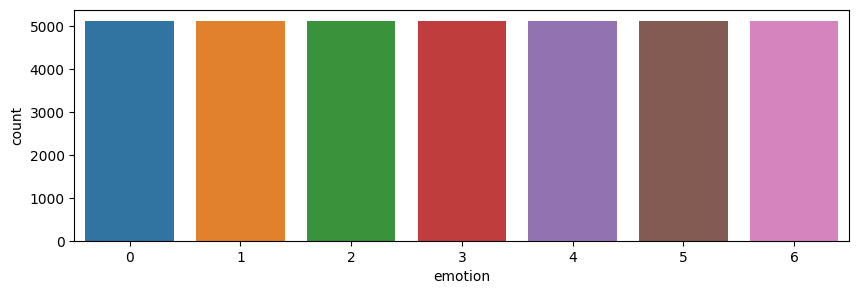

In [87]:
plt.figure(figsize = (10,3))
sns.barplot(x = balanced_data.emotion.value_counts().index, y = balanced_data.emotion.value_counts())

In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(balanced_data['pixels'], balanced_data['emotion'], test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [89]:
np.save('X_train_balanced', X_train)
np.save('X_temp_balanced', X_temp)
np.save('y_train_balanced', y_train)
np.save('y_temp_balanced', y_temp)
np.save('X_val_balanced', X_val)
np.save('X_test_balanced', X_test)
np.save('y_val_balanced', y_val)
np.save('y_test_balanced', y_test)

In [90]:
# Removed from Github but can generate locally
import numpy as np
local_path = "/kaggle/input/fer2013balanced/" 
X_train = np.load(local_path + "X_train_balanced.npy",allow_pickle=True)
X_test = np.load(local_path + "X_test_balanced.npy",allow_pickle=True)
y_train = np.load(local_path + "y_train_balanced.npy",allow_pickle=True)
y_test = np.load(local_path + "y_test_balanced.npy",allow_pickle=True)
X_temp = np.load(local_path + "X_temp_balanced.npy",allow_pickle=True)
X_val = np.load(local_path + "X_val_balanced.npy",allow_pickle=True)
y_temp = np.load(local_path + "y_temp_balanced.npy",allow_pickle=True)
y_val = np.load(local_path + "y_val_balanced.npy",allow_pickle=True)

In [91]:
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 28705
Validation set size: 3588
Test set size: 3589


In [92]:
y_train = to_categorical(y_train)

y_test = to_categorical(y_test)

y_val = to_categorical(y_val)

In [93]:
X_train = np.stack(X_train, axis = 0)
X_train = X_train.reshape(28705 , 48, 48, 1)

X_test = np.stack(X_test, axis = 0)
X_test = X_test.reshape(3589 , 48, 48, 1)

X_val = np.stack(X_val, axis = 0)
X_val = X_val.reshape(3588 , 48, 48, 1)

In [94]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(28705, 48, 48, 1) (28705, 7)
(3589, 48, 48, 1) (3589, 7)
(3588, 48, 48, 1) (3588, 7)


In [95]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_test/255

In [96]:
xception.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [97]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath = "EmotionExpression_weights_balanced_xception.hdf5", verbose = 1, save_best_only=True)

In [98]:
history_Xception = xception.fit(X_train, y_train, batch_size=64,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=len(X_train) // 64,
                            epochs=30,
                            callbacks=[checkpointer, earlystopping])

Epoch 1/30
448/448 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8966
Epoch 1: val_loss improved from inf to 0.37929, saving model to EmotionExpression_weights_balanced_xception.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 92s 137ms/step - loss: 0.3304 - accuracy: 0.8966 - val_loss: 0.3793 - val_accuracy: 0.8779
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9606
Epoch 2: val_loss improved from 0.37929 to 0.34323, saving model to EmotionExpression_weights_balanced_xception.hdf5
448/448 [==============================] - 60s 134ms/step - loss: 0.1270 - accuracy: 0.9606 - val_loss: 0.3432 - val_accuracy: 0.9064
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9699
Epoch 3: val_loss did not improve from 0.34323
448/448 [==============================] - 59s 131ms/step - loss: 0.0954 - accuracy: 0.9699 - val_loss: 0.4461 - val_accuracy: 0.8849
Epoch 4/30
448/448 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9768
Epoch 4: val_loss did not improve from 0.34323
448/448 [==============================] - 59s 131ms/step - loss: 0.0725 - accuracy: 0.9768 - val_l

In [99]:
model_json = xception.to_json()
with open("FacialExpression-balanced-model-Xception.json","w") as json_file:
  json_file.write(model_json)

In [100]:
score = xception.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 2s 15ms/step - loss: 0.5756 - accuracy: 0.8813
Test Accuracy: 0.8813039660453796


In [101]:
predicted_classes = np.argmax(xception.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

113/113 [==============================] - 2s 13ms/step


<Axes: >

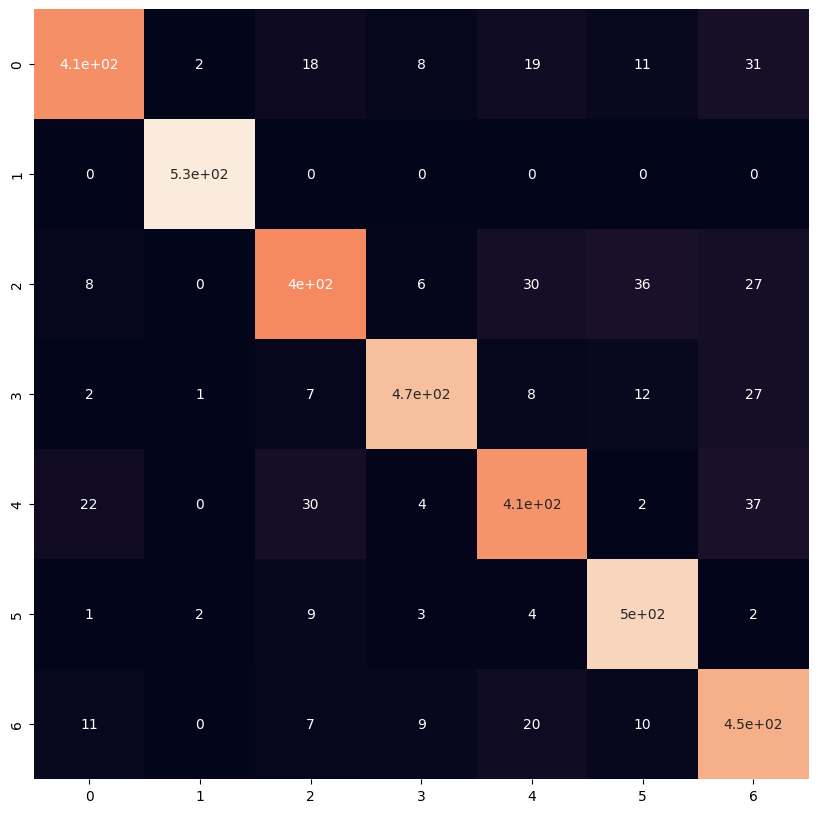

In [102]:
cm_Balanced_Xception = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm_Balanced_Xception, annot = True, cbar = False)

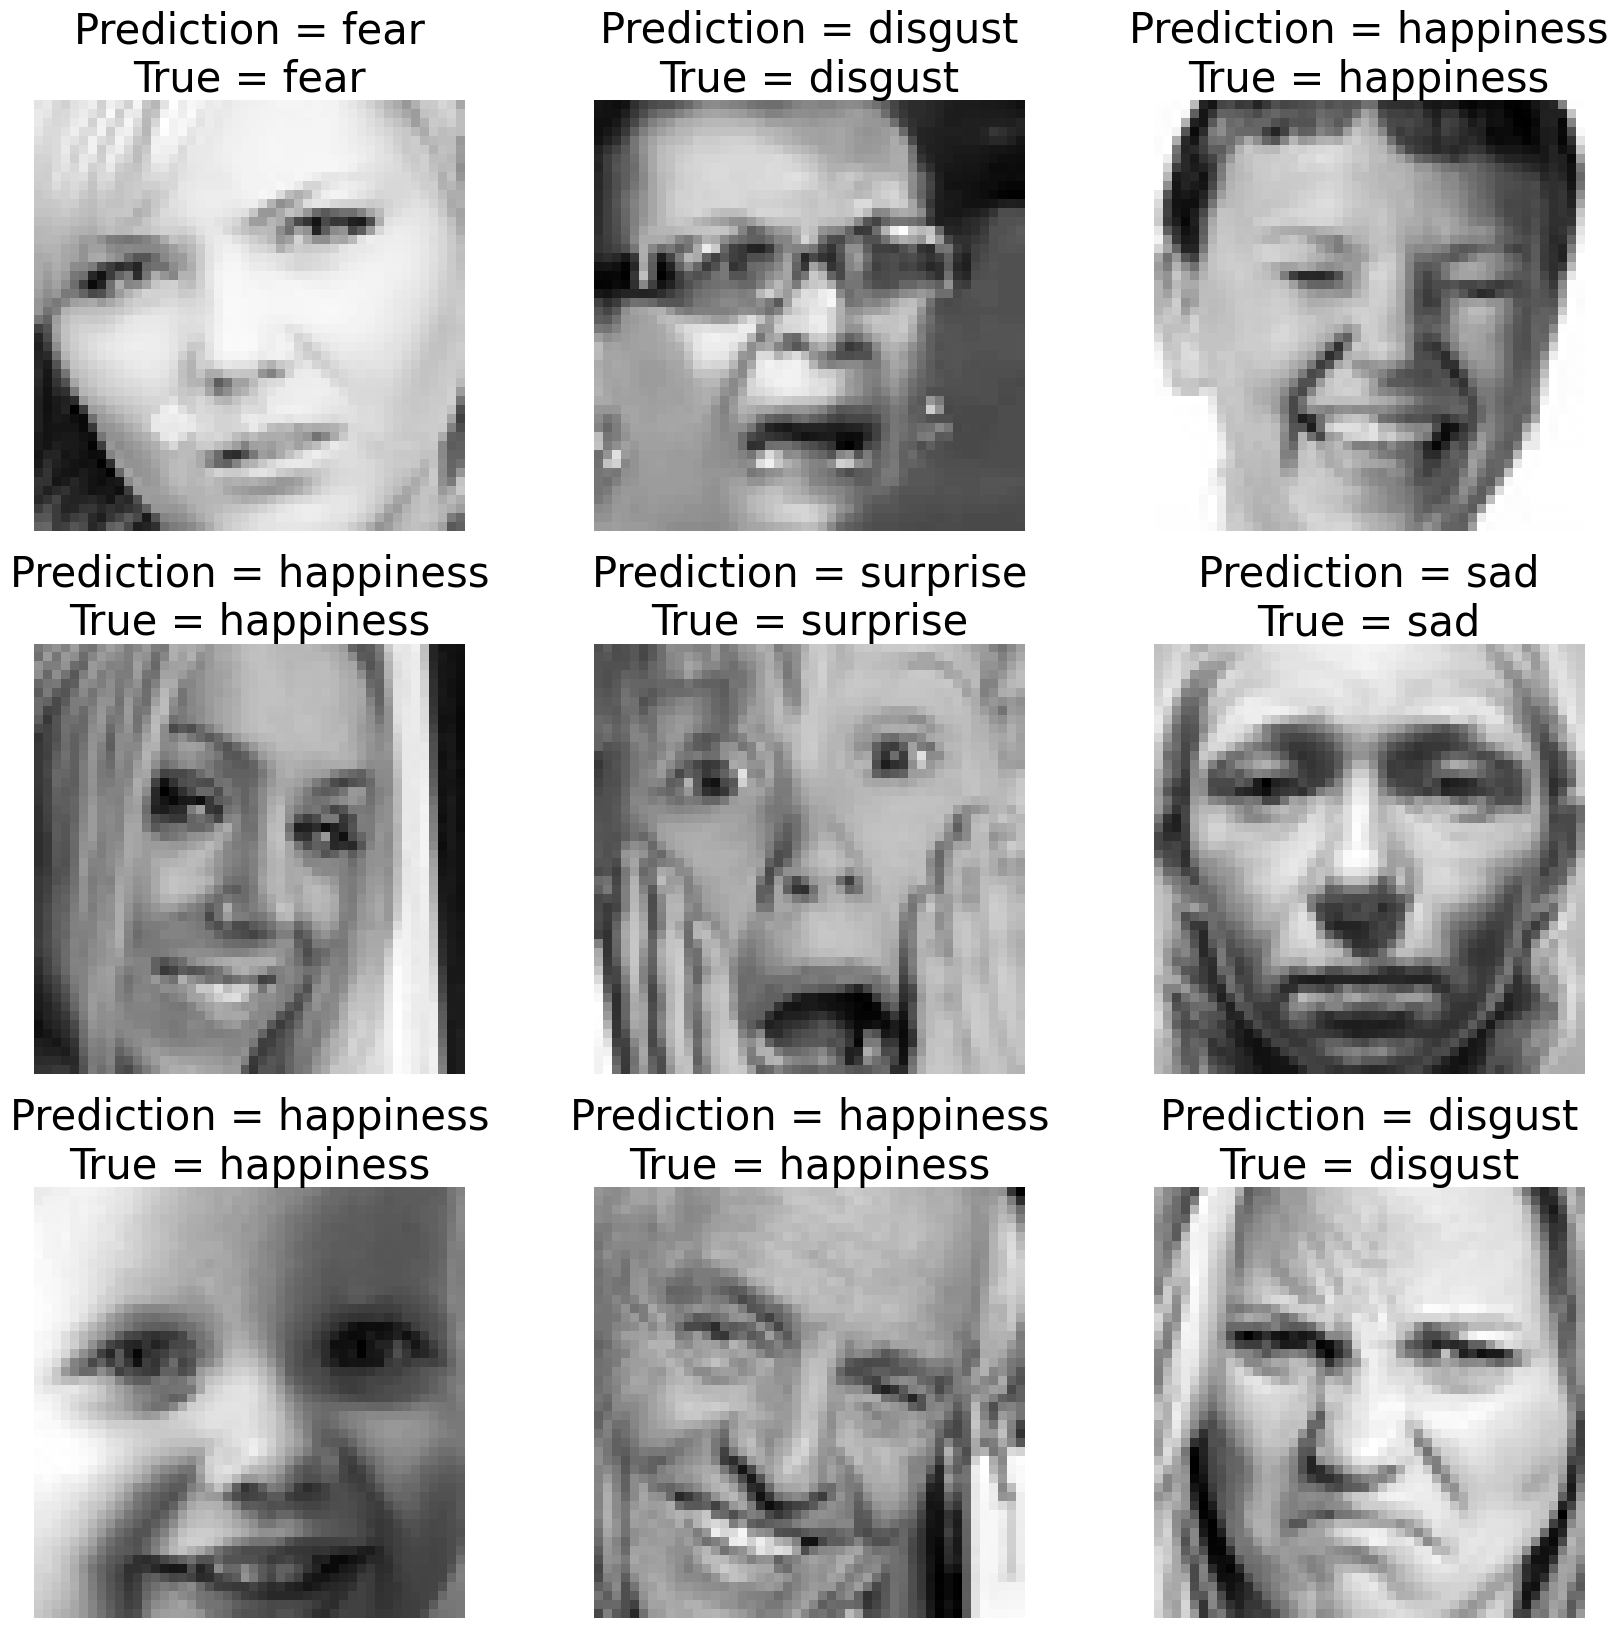

In [103]:
L = 3
W = 3

fig, axes = plt.subplots(L, W, figsize=(20, 20))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(X_test[i].reshape(48, 48), cmap='gray')
    title = 'Prediction = {}\nTrue = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]])
    axes[i].set_title(title, fontsize=30)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [104]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       496
           1       0.99      1.00      1.00       529
           2       0.85      0.79      0.82       506
           3       0.94      0.89      0.92       526
           4       0.84      0.81      0.82       508
           5       0.88      0.96      0.92       520
           6       0.78      0.89      0.83       504

    accuracy                           0.88      3589
   macro avg       0.88      0.88      0.88      3589
weighted avg       0.88      0.88      0.88      3589



Text(0.5, 1.0, 'Accuracy Curves - Xception FER2013 Std')

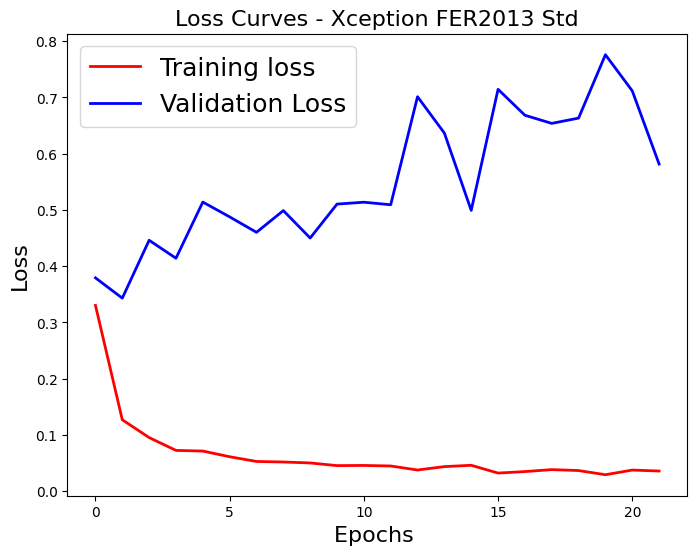

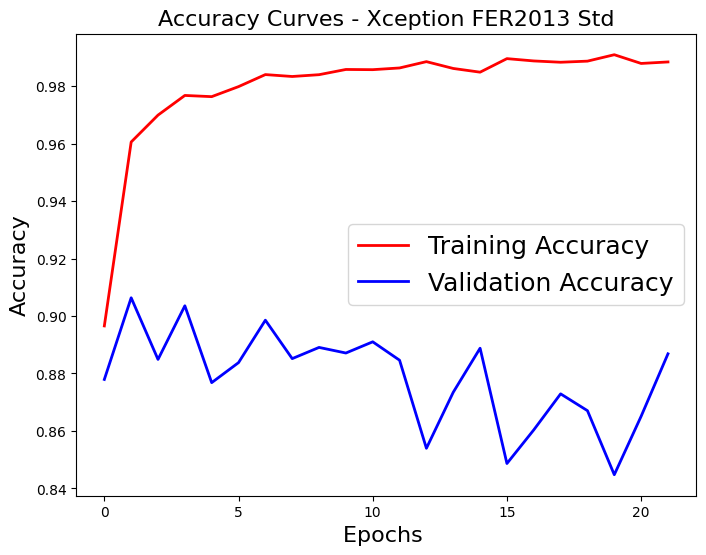

In [105]:
#history_Xception
#Plotting accuracy and loss curves for Xception Model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_Xception.history['loss'],'r',linewidth=2.0)
plt.plot(history_Xception.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves - Xception FER2013 Std',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_Xception.history['accuracy'],'r',linewidth=2.0)
plt.plot(history_Xception.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves - Xception FER2013 Std',fontsize=16)

In [106]:
Resnet18Emo.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)

checkpointer = ModelCheckpoint(filepath = "EmotionExpression_weights_Resnet18Emo.hdf5", verbose = 1, save_best_only=True)
history = Resnet18Emo.fit(X_train, y_train, batch_size=64,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=len(X_train) // 64,
                            epochs=100,
                            callbacks=[checkpointer, earlystopping])

Epoch 1/100
445/448 [============================>.] - ETA: 0s - loss: 0.4671 - accuracy: 0.8438
Epoch 1: val_loss improved from inf to 0.46814, saving model to EmotionExpression_weights_Resnet18Emo.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 21s 18ms/step - loss: 0.4669 - accuracy: 0.8440 - val_loss: 0.4681 - val_accuracy: 0.8439
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9299
Epoch 2: val_loss improved from 0.46814 to 0.44353, saving model to EmotionExpression_weights_Resnet18Emo.hdf5
448/448 [==============================] - 7s 16ms/step - loss: 0.2214 - accuracy: 0.9299 - val_loss: 0.4435 - val_accuracy: 0.8576
Epoch 3/100
446/448 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9592
Epoch 3: val_loss improved from 0.44353 to 0.42036, saving model to EmotionExpression_weights_Resnet18Emo.hdf5
448/448 [==============================] - 7s 16ms/step - loss: 0.1313 - accuracy: 0.9591 - val_loss: 0.4204 - val_accuracy: 0.8779
Epoch 4/100
447/448 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9733
Epoch 4: val_loss did not improve from 0.42036
448/448 [==============================] - 

In [107]:
model_json = Resnet18Emo.to_json()
with open("FacialExpression-balanced-model-Res18.json","w") as json_file:
  json_file.write(model_json)

113/113 [==============================] - 0s 4ms/step - loss: 0.9147 - accuracy: 0.8484
Test Accuracy: 0.8484257459640503
113/113 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       496
           1       0.98      1.00      0.99       529
           2       0.77      0.79      0.78       506
           3       0.89      0.89      0.89       526
           4       0.80      0.70      0.75       508
           5       0.95      0.90      0.92       520
           6       0.76      0.84      0.80       504

    accuracy                           0.85      3589
   macro avg       0.85      0.85      0.85      3589
weighted avg       0.85      0.85      0.85      3589



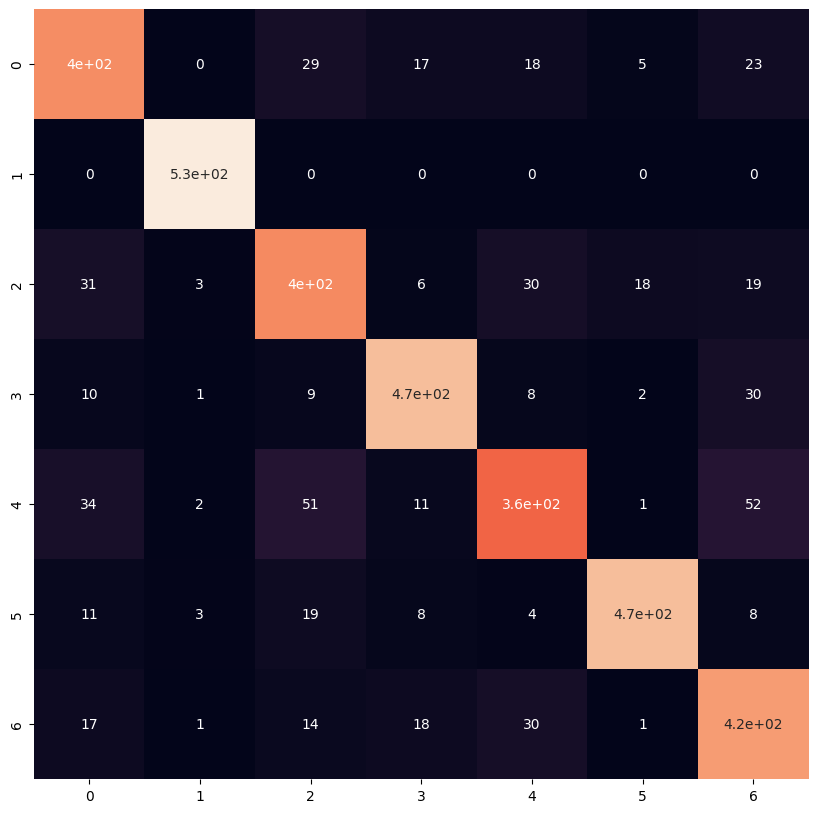

In [108]:
score = Resnet18Emo.evaluate(X_Test, y_test)
print('Test Accuracy: {}'.format(score[1]))
predicted_classes = np.argmax(Resnet18Emo.predict(X_Test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
cm_Balanced_Res = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm_Balanced_Res, annot = True, cbar = False)
print(classification_report(y_true, predicted_classes))

Text(0.5, 1.0, 'Accuracy Curves - Res18Custom FER2013 Std')

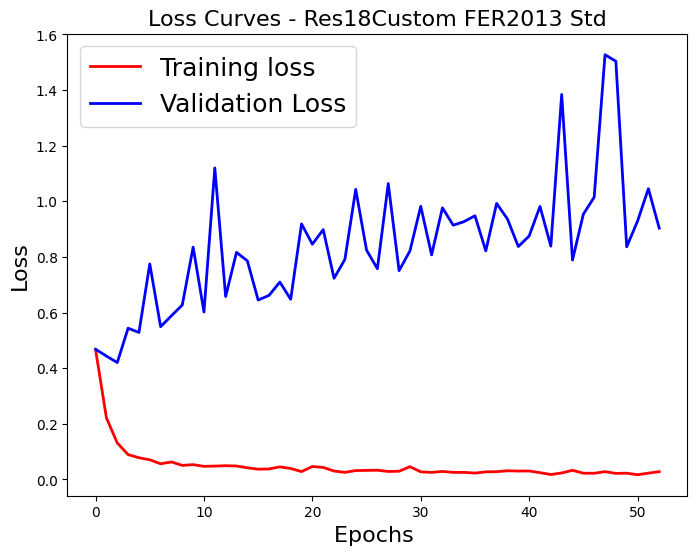

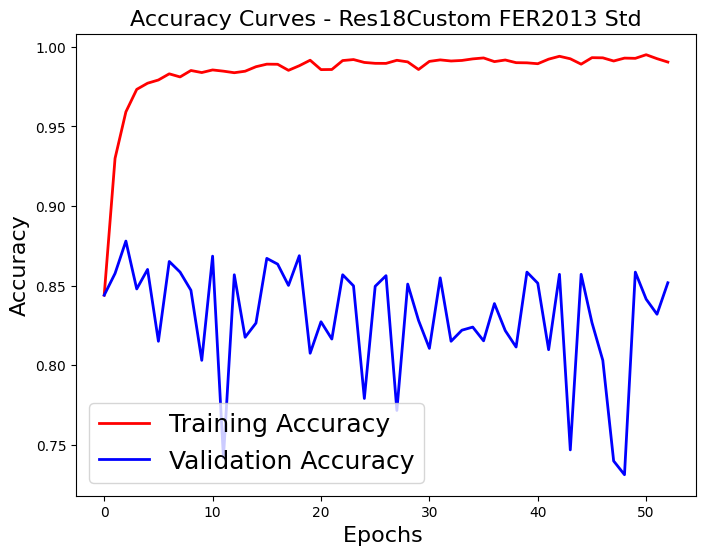

In [109]:
#Plotting accuracy and loss curves for Res18Custom Model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves - Res18Custom FER2013 Std',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves - Res18Custom FER2013 Std',fontsize=16)

# Key Findings:

1. Importance of Balanced Datasets: This project emphasizes the critical role of using a balanced dataset, where each class has an equal number of instances, for effective modeling.

2. Challenges with Class Imbalance: The project encountered imbalanced classes, resulting in biased model performance and skewed predictions due to fewer instances in some categories.

3. Dataset Balancing Strategies: Techniques like oversampling were implemented to rectify class imbalance and create a more balanced dataset.

4. Enhanced Model Performance: The balanced dataset notably enhanced model accuracy, precision, recall, and F1-score across all classes, rendering the model's predictions more reliable and generalizable.

5. Stability in Training: The balanced dataset contributed to a more stable training process, facilitating quicker convergence and reducing overfitting. This enabled the model to acquire a more nuanced understanding of the entire dataset.

6. Equitable Representation: Ensuring fair representation of all classes through a balanced dataset made the results more meaningful and applicable.

7. Significance of Data Preprocessing: This project underscores the pivotal role of data preprocessing in achieving successful outcomes in machine learning.